# Import Libraries

In [2]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import numpy as np

# Model

In [3]:
 # Create a model
model = grb.Model("Model")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-11


# Get data from json

In [4]:
# get the  data from the json file small.json
import json
with open('small.json') as f:
    data = json.load(f)


## Constants from data

In [5]:
horizon= data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications={i['name']:i['qualifications'] for i in data['staff']}
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=dict(zip(job_list,[i['daily_penalty'] for i in data['jobs']]))
job_qualifications=dict(zip(job_list,[i['working_days_per_qualification'] for i in data['jobs']]))
job_gain=dict(zip(job_list,[i['gain'] for i in data['jobs']]))
due_dates=dict(zip(job_list,[i['due_date'] for i in data['jobs']]))
vocation_staff=dict(zip(staff_names,[i['vacations'] for i in data['staff']]))
staff_off={i:{j:1-vocation_staff[i].count(j) for j in jour_list} for i in staff_names}


# Model's parameters

In [6]:
gammak=job_penality
gk=job_gain
lk=due_dates
pi_c = {i:{c:staff_qualifications[i].count(c) for c in qualifications} for i in staff_names}

qk_c={k:{c:job_qualifications[k][c] if c in job_qualifications[k].keys() else 0 for c in qualifications} for k in job_list}
pi_j=staff_off

# Decision variables

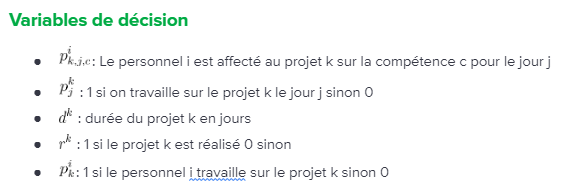

In [ ]:
# constraint M1 and M2
M2=len(qualifications)*len(job_list)
M1=horizon*len(qualifications)
M3 = len(staff_names)
M4=horizon
M5=horizon

In [ ]:
# Add decision variables
# pi_k_j_c: Le personnel i est affecté au projet k sur la compétence c pour le jour j
pi_k_j_c = model.addVars(staff_names,job_list,jour_list,qualifications, vtype=GRB.BINARY, name="pi_k_j_c")

# pk_j : 1 si on travaille sur le projet k le jour j sinon 0
zk_j = model.addVars(job_list,jour_list,vtype=GRB.BINARY, name="zk_j")

# rk : 1 si le projet k est réalisé 0 sinon
rk = model.addVars( job_list,vtype=GRB.BINARY, name="rk")
# worked days per day and per qualification
wk_c=model.addVars(job_list,qualifications,vtype=GRB.INTEGER, name="wk_c")

# end_k : date de fin du projet k
end_k=model.addVars(job_list,vtype=GRB.INTEGER, name="end_k")

# delay_k: le nombre de jours en retard du projet k
delay_k=model.addVars(job_list,vtype=GRB.INTEGER, name="delay_k")

# start_k le jour auquel on commence le projet k
start_k=model.addVars(job_list,vtype=GRB.INTEGER, name="start_k")

# Constraints

In [ ]:

# for i in staff_names: 
#     for j in jour_list :
#         model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for k in job_list for c in qualifications) <=1, name=f"contrainte2{i}_{j}")
#         for k in job_list :
#             for c in qualifications:
#                 model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_c[i][c]) <=1, name=f"contrainte1{i}_{k}_{j}_{c}")
#                 model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_j[i][j]) <=1, name=f"contrainte3{i}_{k}_{j}_{c}")
#                 model.addConstr(end_k[k]>= pi_k_j_c[i,k,j,c]*j , name=f"contrainte10_end{k}")
# for k in job_list :
#     for c in qualifications:        
#         model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) <=qk_c[k][c], name=f"contrainte4{k}_{c}")
#         model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list)<=wk_c[k,c] , name = f"contrainte9_w{k,c}")
#         model.addConstr(rk[k]*wk_c[k,c] <= grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list)  , name = f"contrainte8_rk{k,c}")
# for k in job_list:
#     for j in jour_list:
#         model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for c in qualifications) -  1 <= M3*zk_j[k,j]-0.01 , name = f"contrainte5{k}_{j}")
#         model.addConstr(-M3*(1-zk_j[k,j])<=grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for c in qualifications) -  1  , name = f"contrainte6{k}_{j}")
# for k in job_list:
#     model.addConstr(end_k[k]-due_dates[k]<=delay_k[k] , name=f"contrainte11_delay_k{k}")
#     model.addConstr(start_k[k]>= end_k[k]-grb.quicksum(zk_j[k,j] for j in jour_list)+1 , name=f"contrainte12_start_k{k}")

    

In [ ]:
#Un personnel i peut être associé au projet k que s’il possède la compétence c nécessaire pour le projet :
#3.
constr3={f'p{i}_{k}_{j}_{c}':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_c[i][c]) <=1, name=f"contrainte3{i}_{k}_{j}_{c}")
    for i in staff_names for k in job_list 
       for j in jour_list  for c in qualifications }
#4.
constr4={f'p{i}_{j}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for k in job_list for c in qualifications) <=1, name=f"contrainte4{i}_{j}")
    for i in staff_names for j in jour_list}
# 5.  
constr5={f'2p{i}_{k}_{j}_{c}':model.addConstr(pi_k_j_c[i,k,j,c]  + (1-pi_j[i][j]) <=1, name=f"contrainte5{i}_{k}_{j}_{c}")
    for i in staff_names for k in job_list 
       for j in jour_list  for c in qualifications }
# 6.
contr6={f'p2{k}_{c}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) <=qk_c[k][c], name=f"contrainte6{k}_{c}")
    for k in job_list 
    for c in qualifications }

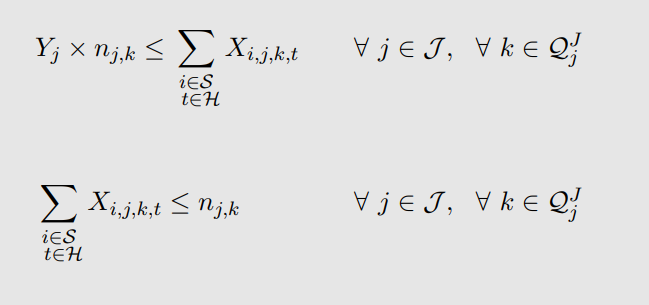

In [ ]:
# constr8={f'wk_c{k}_{c}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list)<=wk_c[k,c] , name = f"contrainte8{k,c}")
# for k in job_list
# for c in qualifications}
# constr9={f'rk{k}':model.addConstr(rk[k]*wk_c[k,c] <= grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list)  , name = f"contrainte9{k}")
# for k in job_list
# for c in qualifications}

In [ ]:
# 8.
constr8={f'p_q{k}':model.addConstr(-M2*(1-rk[k])+0.01 <= grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) -qk_c[k][c]+1, name = f"contrainte8{k}")
        for k in job_list
        for c in qualifications
        }
constr9={f'p_q2{k}':model.addConstr( grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for j in jour_list) -qk_c[k][c]+1 <=M2*rk[k], name = f"contrainte9{k}")
        for k in job_list
        for c in qualifications
        }
9.

constr10 = {f'z{k}_{j}':model.addConstr(grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for c in qualifications) -  1 <= M3*zk_j[k,j]-0.01 , name = f"contrainte10{k}_{j}")
        for k in job_list
          for j in jour_list}

constr11 = {f'z2{k}_{j}':model.addConstr(-M3*(1-zk_j[k,j])<=grb.quicksum(pi_k_j_c[i,k,j,c] for i in staff_names for c in qualifications) -  1  , name = f"contrainte11{k}_{j}")
        for k in job_list
          for j in jour_list}



In [ ]:
# 10.
contr12={f'end_k{k}':model.addConstr(end_k[k]>= pi_k_j_c[i,k,j,c]*j , name=f"contrainte12end{k}")
for i in staff_names for j in jour_list 
for k in job_list for c in qualifications }
contr13={f'delay_k{k}':model.addConstr(end_k[k]-due_dates[k]<=delay_k[k] , name=f"contrainte13delay_k{k}")
for k in job_list }

# contr14={f'start_k{k}':model.addConstr(start_k[k]>= end_k[k]-grb.quicksum(zk_j[k,j] for j in jour_list)+1 , name=f"contrainte14start_k{k}")
# for k in job_list }



In [ ]:
# Fonction Objectif
model.setObjectiveN(grb.quicksum((job_gain[k]*rk[k]) - delay_k[k]*job_penality[k] for k in job_list), 0,GRB.MAXIMIZE)  
# model.setObjectiveN(grb.quicksum(zk_j[k,j] for k in job_list for j in jour_list),1, GRB.MINIMIZE)  

# Paramétrage (mode mute)
model.params.outputflag = 0
# Résolution du PL
model.optimize()

In [ ]:
#model.computeIIS()
model.write("model.lp")
#  print constraints of the gurobipy.Model

In [ ]:
model.ObjVal

54.0

In [ ]:
values= []
for k, v in pi_k_j_c.items():
    values.append(v.x)

In [ ]:
res = pd.DataFrame(list(pi_k_j_c.keys()))
res[4] = values
result = res[res[4] == 1]
result

,0,1,2,3,4
18,Olivia,Job2,2,A,1.0
22,Olivia,Job2,3,B,1.0
41,Olivia,Job3,4,C,1.0
58,Olivia,Job4,5,B,1.0
62,Olivia,Job5,1,C,1.0
97,Liam,Job2,3,B,1.0
108,Liam,Job3,2,A,1.0
130,Liam,Job4,4,B,1.0
191,Emma,Job3,4,C,1.0
203,Emma,Job4,3,C,1.0


## Result Table

In [ ]:
def color_table(x):
    if pd.isna(x):
        return "background-color: white"
    else:
        if "Job1" in x :
            return "background-color: blue"
        elif "Job2" in x:
            return "background-color: black"
        elif "Job3" in x:
            return "background-color: orange"
        elif "Job4" in x:
           return "background-color: grey"
        elif "Job5" in x:
           return "background-color: green"
        elif "Job6" in x:
              return "background-color: yellow"
        elif "Job7" in x:
              return "background-color: pink"
        elif "Job8" in x:
                return "background-color: purple"
        elif "Job9" in x:
                return "background-color: brown"
        elif "Job10" in x:
                return "background-color: cyan"
        elif "Job11" in x:
            return "background-color: magenta"
        elif "Job12" in x:
            return "background-color: lime"
        else:
           return  "background-color: red"

In [ ]:
df = pd.DataFrame(columns = [i for i in range(1,6)], index = staff_names)

for ind, val in result.iterrows():
    col = val[2]
    row = val[0]
    v = val[3] + " " + val[1]
    df.loc[row,col] = v
    # vacation
    for staff in staff_names:
        for day in jour_list:
            if pi_j[staff][day] == 0:
                df.loc[staff,day] = 'X'

df.style.applymap(color_table)

,1,2,3,4,5
Olivia,C Job5,A Job2,B Job2,C Job3,B Job4
Liam,X,A Job3,B Job2,B Job4,nan
Emma,C Job5,X,C Job4,C Job3,nan


In [ ]:
rk

{'Job1': <gurobi.Var rk[Job1] (value 0.0)>,
 'Job2': <gurobi.Var rk[Job2] (value 1.0)>,
 'Job3': <gurobi.Var rk[Job3] (value 1.0)>,
 'Job4': <gurobi.Var rk[Job4] (value 1.0)>,
 'Job5': <gurobi.Var rk[Job5] (value 1.0)>}

In [ ]:
zk_j

{('Job1', 1): <gurobi.Var zk_j[Job1,1] (value 0.0)>,
 ('Job1', 2): <gurobi.Var zk_j[Job1,2] (value 0.0)>,
 ('Job1', 3): <gurobi.Var zk_j[Job1,3] (value 0.0)>,
 ('Job1', 4): <gurobi.Var zk_j[Job1,4] (value 0.0)>,
 ('Job1', 5): <gurobi.Var zk_j[Job1,5] (value 0.0)>,
 ('Job2', 1): <gurobi.Var zk_j[Job2,1] (value 0.0)>,
 ('Job2', 2): <gurobi.Var zk_j[Job2,2] (value 1.0)>,
 ('Job2', 3): <gurobi.Var zk_j[Job2,3] (value 1.0)>,
 ('Job2', 4): <gurobi.Var zk_j[Job2,4] (value -0.0)>,
 ('Job2', 5): <gurobi.Var zk_j[Job2,5] (value -0.0)>,
 ('Job3', 1): <gurobi.Var zk_j[Job3,1] (value -0.0)>,
 ('Job3', 2): <gurobi.Var zk_j[Job3,2] (value 1.0)>,
 ('Job3', 3): <gurobi.Var zk_j[Job3,3] (value -0.0)>,
 ('Job3', 4): <gurobi.Var zk_j[Job3,4] (value 1.0)>,
 ('Job3', 5): <gurobi.Var zk_j[Job3,5] (value -0.0)>,
 ('Job4', 1): <gurobi.Var zk_j[Job4,1] (value -0.0)>,
 ('Job4', 2): <gurobi.Var zk_j[Job4,2] (value -0.0)>,
 ('Job4', 3): <gurobi.Var zk_j[Job4,3] (value 1.0)>,
 ('Job4', 4): <gurobi.Var zk_j[Job4,4] 

In [ ]:
start_k

{'Job1': <gurobi.Var start_k[Job1] (value -0.0)>,
 'Job2': <gurobi.Var start_k[Job2] (value -0.0)>,
 'Job3': <gurobi.Var start_k[Job3] (value -0.0)>,
 'Job4': <gurobi.Var start_k[Job4] (value -0.0)>,
 'Job5': <gurobi.Var start_k[Job5] (value -0.0)>}

In [ ]:
end_k

{'Job1': <gurobi.Var end_k[Job1] (value 0.0)>,
 'Job2': <gurobi.Var end_k[Job2] (value 3.0)>,
 'Job3': <gurobi.Var end_k[Job3] (value 4.0)>,
 'Job4': <gurobi.Var end_k[Job4] (value 5.0)>,
 'Job5': <gurobi.Var end_k[Job5] (value 1.0)>}

In [ ]:
zk_j

{('Job1', 1): <gurobi.Var zk_j[Job1,1] (value 0.0)>,
 ('Job1', 2): <gurobi.Var zk_j[Job1,2] (value 0.0)>,
 ('Job1', 3): <gurobi.Var zk_j[Job1,3] (value 0.0)>,
 ('Job1', 4): <gurobi.Var zk_j[Job1,4] (value 0.0)>,
 ('Job1', 5): <gurobi.Var zk_j[Job1,5] (value 0.0)>,
 ('Job2', 1): <gurobi.Var zk_j[Job2,1] (value 0.0)>,
 ('Job2', 2): <gurobi.Var zk_j[Job2,2] (value 1.0)>,
 ('Job2', 3): <gurobi.Var zk_j[Job2,3] (value 1.0)>,
 ('Job2', 4): <gurobi.Var zk_j[Job2,4] (value -0.0)>,
 ('Job2', 5): <gurobi.Var zk_j[Job2,5] (value -0.0)>,
 ('Job3', 1): <gurobi.Var zk_j[Job3,1] (value -0.0)>,
 ('Job3', 2): <gurobi.Var zk_j[Job3,2] (value 1.0)>,
 ('Job3', 3): <gurobi.Var zk_j[Job3,3] (value -0.0)>,
 ('Job3', 4): <gurobi.Var zk_j[Job3,4] (value 1.0)>,
 ('Job3', 5): <gurobi.Var zk_j[Job3,5] (value -0.0)>,
 ('Job4', 1): <gurobi.Var zk_j[Job4,1] (value -0.0)>,
 ('Job4', 2): <gurobi.Var zk_j[Job4,2] (value -0.0)>,
 ('Job4', 3): <gurobi.Var zk_j[Job4,3] (value 1.0)>,
 ('Job4', 4): <gurobi.Var zk_j[Job4,4] 

In [ ]:
pi_j

{'Olivia': {1: 1, 2: 1, 3: 1, 4: 1, 5: 1},
 'Liam': {1: 0, 2: 1, 3: 1, 4: 1, 5: 1},
 'Emma': {1: 1, 2: 0, 3: 1, 4: 1, 5: 1}}

In [ ]:
# for k in job_list:
for j in jour_list:
    print(zk_j['Job5',j])


<gurobi.Var zk_j[Job5,1] (value 1.0)>
<gurobi.Var zk_j[Job5,2] (value -7.771561172374882e-14)>
<gurobi.Var zk_j[Job5,3] (value 0.0)>
<gurobi.Var zk_j[Job5,4] (value 0.0)>
<gurobi.Var zk_j[Job5,5] (value 0.0)>


In [ ]:
for j in jour_list:
    for s in staff_names:
        for c in  qualifications:
            print(pi_k_j_c[s,'Job1',j,c])

<gurobi.Var pi_k_j_c[Olivia,Job1,1,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,1,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,1,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,1,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,1,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,1,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,1,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,1,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,1,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,2,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,2,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,2,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,2,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,2,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Liam,Job1,2,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,2,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,2,B] (value 0.0)>
<gurobi.Var pi_k_j_c[Emma,Job1,2,C] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,3,A] (value 0.0)>
<gurobi.Var pi_k_j_c[Olivia,Job1,3,B] (value 0.0)>
<gur

In [ ]:
end_k

{'Job1': <gurobi.Var end_k[Job1] (value 0.0)>,
 'Job2': <gurobi.Var end_k[Job2] (value 3.0)>,
 'Job3': <gurobi.Var end_k[Job3] (value 4.0)>,
 'Job4': <gurobi.Var end_k[Job4] (value 5.0)>,
 'Job5': <gurobi.Var end_k[Job5] (value 1.0)>}

In [ ]:
delay_k

{'Job1': <gurobi.Var delay_k[Job1] (value -0.0)>,
 'Job2': <gurobi.Var delay_k[Job2] (value 0.0)>,
 'Job3': <gurobi.Var delay_k[Job3] (value 0.0)>,
 'Job4': <gurobi.Var delay_k[Job4] (value 2.0)>,
 'Job5': <gurobi.Var delay_k[Job5] (value -0.0)>}